In [1]:
%run -i "loaddata.py"
plt.rcParams["font.size"] = 13
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
save = False

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


In [2]:
# Collect all data into 1 array
keys = tuple(data_dict.keys())[::2]

data = []
for key in keys:
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]):
            data.append(vec)
data = np.array(data)
print(data.shape)
features = data_dict[ list(data_dict.keys())[1] ]

(1358, 28)


# All time series in a single plot

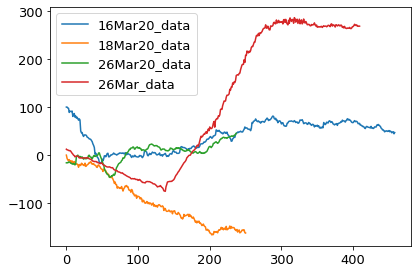

In [3]:
lengths = [len(data_dict[keys[i]]) for i in range(len(keys))]

plt.figure()
for key in keys:
    plot_data = data_dict[key][:,1]
    plot_data = plot_data[np.isnan(plot_data) != True]
    plt.plot(plot_data, label=key)
plt.legend()
plt.tight_layout()
plt.show()

# sklearn time
## XGBoost

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[:,3:], data[:,1], test_size=0.25)

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

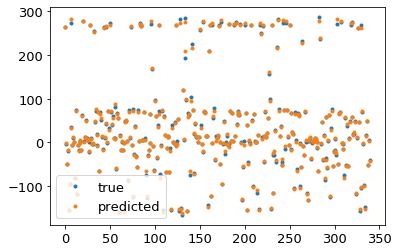

RMS = 3.241


In [5]:
plt.figure()
plt.plot(y_test, '.',label="true")
plt.plot(y_pred, '.', label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### New Split Shit

In [6]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

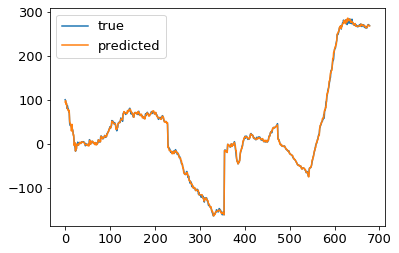

RMS = 2.830


In [7]:
plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Predict 1 timeseries

In [25]:
def test_1_timeseries(test_nr):
    # Choose which timeseries to test on with "timeseries_nr"
    # Make new test and train
    keyss = [keys[i] for i in range(4) if i!=test_nr]

    train = []
    for key in keyss:
        for vec in data_dict[key]:
            if not np.isnan(vec[0]):
                train.append(vec)
    train = np.array(train)

    test = []
    for vec in data_dict[keys[test_nr]]:
        if not np.isnan(vec[0]):
            test.append(vec)
    test = np.array(test)
    return np.copy(train[:,3:]), np.copy(test[:,3:]), np.copy(train[:,1]), np.copy(test[:,1])

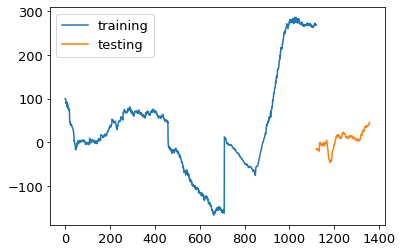

In [26]:
X_train, X_test, y_train, y_test = test_1_timeseries(2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [27]:
# Fit
mlp = xgb.XGBRegressor()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

In [37]:
# Create a model with no hyperparameters
clf_xgb = xgb.XGBRegressor(random_state=42, n_jobs=4)

# Parameters to search
parameters_RandomSearch = {
    "n_estimators": st.randint(1,10),
    "max_depth": st.randint(1,10),
    "learning_rate": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.5s


Random Search: 	Best parameters:  {'learning_rate': 0.8445338486781514, 'max_depth': 2, 'n_estimators': 5} , Best scores: -3.2701


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished


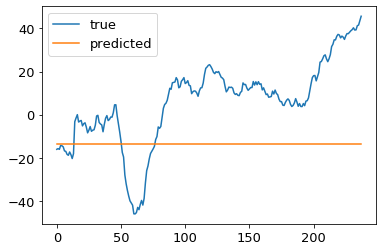

RMS = 27.168


In [38]:
y_pred = RandomSearch.predict(X_test)

plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## NN

In [12]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [13]:
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


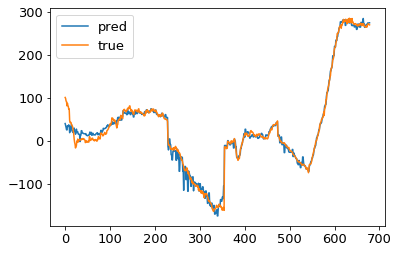

In [14]:
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV random search

In [15]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu", "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=10),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1)

# fit the random search instance
RandomSearch.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.2s finished


In [16]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'tanh', 'hidden_layer_sizes': (64, 55, 14, 8, 2, 1, 1, 1), 'learning_rate_init': 0.04043358953843135} , Best scores: -1.0258


87.46029875310911


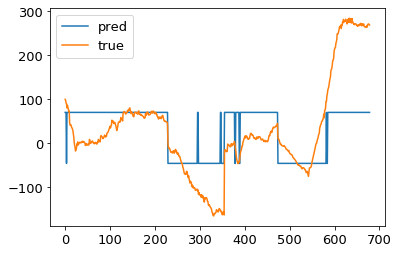

In [17]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
print(rms)
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### Predict one timeseries

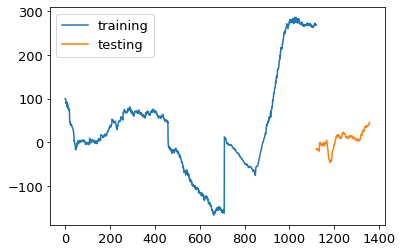

In [18]:
X_train, X_test, y_train, y_test = test_1_timeseries(2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [19]:
# Scale the data
# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [20]:
# Fit
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

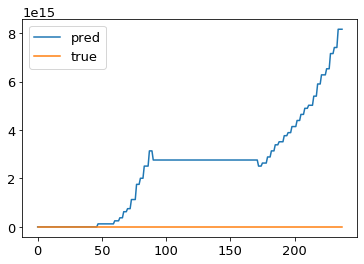

In [21]:
# Plotting
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV

In [22]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu", "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=10),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 50

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1)

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 243 out of 250 | elapsed:   21.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   21.6s finished


In [23]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (61,), 'learning_rate_init': 0.046450412719997725} , Best scores: -2.1942


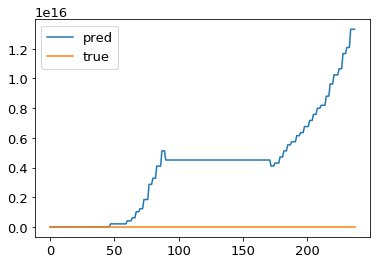

In [24]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()